# **FINGERPRINT RECOGNITION**

Ứng dụng mạng học sâu vào mô hình nhận dạng dấu vân tay.

Nội dung của `nootbook` này sẽ nói về việc cài đặt và huấn luyện sao cho mô hình có thể nhận dạng được dấu vân tay bất kì là của người nào trong bộ dữ liệu.

Kết quả trả về sẽ là `ID` của người đó trong bộ dữ liệu và ngón dấu vân tay đó là ngón nào, của bàn tay bên nào.

In [35]:
# Khai báo các thư viện cơ bản
import os
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [36]:
# Nếu run all trên local thì ta sẽ chọn local,
# Nếu run all trên colab thì ta sẽ chọn colab
RUNTYPE = 'colab'

In [37]:
IMAGE_SIZE = 90

# Số lượng mạng, model mà ta sẽ dùng đễ nhận dạng
NETS = 2

# Lớp dense cuối cùng để ta phân lớp (classify) tương ứng với từng class
FINAL_DENSE_UNITS = [600, 10]

# Tên của từng model
MODEL_NAME = ['SubjectID_Model', 'FingerNum_Model']

# Model mà ta lựa chọn, có 2 model: base và vit-ft
TYPE_MODEL = 'base'

In [38]:
if RUNTYPE == 'local':
    ROOT_DB = '..'
    # Địa chỉ lưu trữ model sau khi train
    SAVE_MODEL_FILE_DIR = './runs/'
else:
    from google.colab import drive
    drive.mount('/content/drive/')

    try:
        os.mkdir('/content/runs')
    except Exception as e:
        print(e)

    try:
        os.listdir('/content/SOCOFing-npz')
    except:
        # Chỉnh sửa chổ này thành nơi lưu dataset
        !unzip '/content/drive/MyDrive/SyncPC/Biometric/SOCOFing-npz.zip'

    ROOT_DB = '/content/'
    SAVE_MODEL_FILE_DIR = '/content/runs/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 17] File exists: '/content/runs'


In [39]:
len_train_dir = 0
try:
    len_train_dir = len(os.listdir(SAVE_MODEL_FILE_DIR))
except:
    pass

TRAIN_DIR = f'{SAVE_MODEL_FILE_DIR}/train{len_train_dir}/'
os.mkdir(TRAIN_DIR)

### 1. DATASET - `SOCOFing-npz`

Load dataset

In [40]:
x_real = np.load(f'{ROOT_DB}/SOCOFing-npz/x_real.npz')['data']
y_real = np.load(f'{ROOT_DB}/SOCOFing-npz/y_real.npy')

x_easy = np.load(f'{ROOT_DB}/SOCOFing-npz/x_easy.npz')['data']
y_easy = np.load(f'{ROOT_DB}/SOCOFing-npz/y_easy.npy')

x_medium = np.load(f'{ROOT_DB}/SOCOFing-npz/x_medium.npz')['data']
y_medium = np.load(f'{ROOT_DB}/SOCOFing-npz/y_medium.npy')

x_hard = np.load(f'{ROOT_DB}/SOCOFing-npz/x_hard.npz')['data']
y_hard = np.load(f'{ROOT_DB}/SOCOFing-npz/y_hard.npy')

In [41]:
## In ra file csv để kiểm tra dữ liệu label có ý nghĩa là gì
# import pandas as pd
# pd.DataFrame(y_real).sort_values(by= [0, 2, 3]).to_csv('./y_real.csv', index = False)
# pd.DataFrame(y_easy).sort_values(by= [0, 2, 3]).to_csv('./y_easy.csv',  index = False)
# pd.DataFrame(y_medium).sort_values(by= [0, 2, 3]).to_csv('./y_medium.csv',  index = False)
# pd.DataFrame(y_hard).sort_values(by= [0, 2, 3]).to_csv('./y_hard.csv',  index = False)

Kiểm tra kích thước của dataset

In [42]:
print("Shapes:\t\t\t\t\t  Feature shape\t\t Label shape")
print("-----------------------------------------------------------------------------")
print(f"Finger Real data:\t\t\t{x_real.shape}\t  {y_real.shape}")
print(f"Finger Altered Easy data:\t\t{x_easy.shape}\t  {y_easy.shape}")
print(f"Finger Altered Medium data:\t\t{x_medium.shape}\t  {y_medium.shape}")
print(f"Finger Altered Hard data:\t\t{x_hard.shape}\t  {y_hard.shape}")

Shapes:					  Feature shape		 Label shape
-----------------------------------------------------------------------------
Finger Real data:			(6000, 90, 90, 1)	  (6000, 4)
Finger Altered Easy data:		(17931, 90, 90, 1)	  (17931, 4)
Finger Altered Medium data:		(17067, 90, 90, 1)	  (17067, 4)
Finger Altered Hard data:		(14272, 90, 90, 1)	  (14272, 4)


Phát hoạ một vài dấu vân tay trong dataset

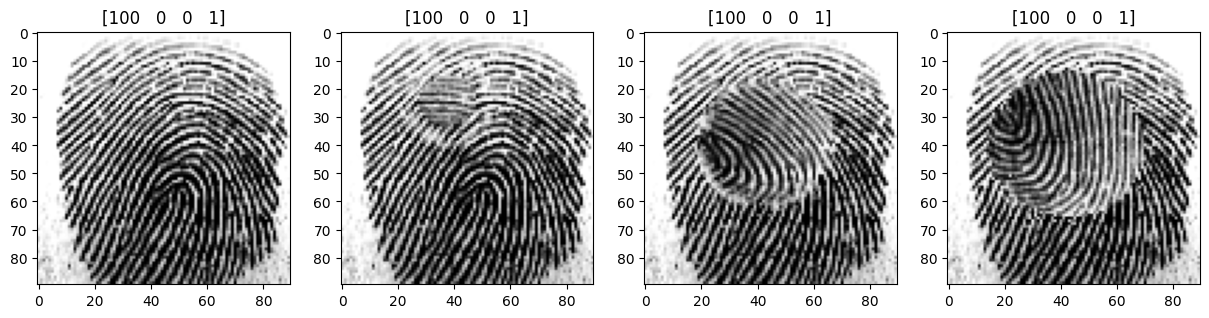

In [43]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')

### 2. PREPROCESSING DATASET

#### 2.1. Split dataset

Trước khi split dataset, ta sẽ gộp các dấu vân tay thuộc bộ dữ liệu dấu tay bị ảnh hưởng bởi ngoại cảnh.

In [44]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis = 0)
label_data = np.concatenate([y_easy, y_medium, y_hard], axis = 0)

del x_easy, x_medium, x_hard, y_easy, y_medium, y_hard

Ta sẽ chỉ lấy 2 nội dung của `label_data`:
- **Nội dung 1:** ID, mã định danh của một người nào đó trong dataset.
- **Nội dung 2:** Thứ tự của ngón tay trong dataset.
    - Ta đã biết, ở cột 2 của label_data thì là tay trái (left) = 0 và tay phải (right) = 1, ta sẽ gọi đây là `hand`.
    - Thứ tự của ngón tay (`fing`) trên bàn tay được đánh dấu lần lượt là:
        - 0: Ngót út
        - 1: Ngón áp út
        - 2: Ngón giữa
        - 3: Ngón trỏ
        - 4: Ngón danh
    - Do đó, ta sẽ gom theo thứ tự từ 1 -> 10, tương ứng với 10 ngón, và ta sẽ có công thức: `fingNum = hand * 5 + fing`

In [45]:
label_data[:, 1] = label_data[:, 2] * 5 + label_data[:, 3]
label_data[:, 0] = label_data[:, 0] - 1
label_data = label_data[:, :2]
label_data

array([[99,  1],
       [99,  1],
       [99,  1],
       ...,
       [ 8,  5],
       [ 8,  5],
       [ 8,  5]], dtype=uint16)

In [46]:
from sklearn.model_selection import train_test_split

Chia bộ dữ liệu thành 2 tập `[train, val]` theo tỉ lệ `[0.8, 0.2]`

In [47]:
# Split dataset to train/val ~ 0.8/0.2
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data,
                                                          test_size = 0.2,
                                                          random_state = 42)

Tập dữ liệu `test` chính là tập real của bộ dữ liệu, và ta cũng sẽ đánh dấu lại `label_test` giống như `label_data`.

In [48]:
x_test = x_real

label_test = y_real
label_test[:, 1] = y_real[:, 2] * 5 + y_real[:, 3]
label_test[:, 0] = y_real[:, 0] - 1
label_test = label_test[:, :2]

del x_real, y_real

Kiểm tra lại dữ liệu đã chia

In [49]:
print("Shapes:\t\t\t\t\t  Feature shape\t\t Label shape")
print("-----------------------------------------------------------------------------")
print(f"Finger Full data:\t\t\t{x_data.shape}\t  {label_data.shape}")
print(f"Finger Train data:\t\t\t{x_train.shape}\t  {label_train.shape}")
print(f"Finger Valid data:\t\t\t{x_val.shape}\t  {label_val.shape}")
print(f"Finger Test data:\t\t\t{x_test.shape}\t  {label_test.shape}")

Shapes:					  Feature shape		 Label shape
-----------------------------------------------------------------------------
Finger Full data:			(49270, 90, 90, 1)	  (49270, 2)
Finger Train data:			(39416, 90, 90, 1)	  (39416, 2)
Finger Valid data:			(9854, 90, 90, 1)	  (9854, 2)
Finger Test data:			(6000, 90, 90, 1)	  (6000, 2)


#### 2.2. Convert to categorical label

Bởi vì label của từng người là một numerical, do đó nếu đưa label vào train ta sẽ không đạt được đúng mục đích.

Do đó, ta sẽ chuyển label từ dạng `numerical` sang `categorical` với số lượng lớp tương ứng từng mục đích:
- Với model phân loại `ID`: Ta sẽ có `600` class, tương ứng với 600 người trong dataset.
- Với model phân loại `fingerNum`: Ta sẽ có `10` class, tương ứng với 10 ngón tay.

In [50]:
from keras.utils import to_categorical

In [51]:
y_SubjectID_data = to_categorical(label_data[:, 0], num_classes= 600)
y_SubjectID_train = to_categorical(label_train[:, 0], num_classes= 600)
y_SubjectID_val = to_categorical(label_val[:, 0], num_classes= 600)
y_SubjectID_test = to_categorical(label_test[:, 0], num_classes= 600)

y_fingerNum_data = to_categorical(label_data[:, 1], num_classes= 10)
y_fingerNum_train = to_categorical(label_train[:, 1], num_classes= 10)
y_fingerNum_val = to_categorical(label_val[:, 1], num_classes= 10)
y_fingerNum_test = to_categorical(label_test[:, 1], num_classes= 10)

Kiểm tra lại dữ liệu lần cuối trước khi ta chuyển sang xây dựng và huấn luyện model

In [52]:
print("Shapes:                  Feature shape    label shape")
print("----------------------------------------------------")
print("full SubjectID data:  ", x_data.shape, y_SubjectID_data.shape)
print("SubjectID_Train:      ", x_train.shape, y_SubjectID_train.shape)
print("SubjectID_Validation: ", x_val.shape, y_SubjectID_val.shape)
print("SubjectID_Test:       ", x_test.shape, y_SubjectID_test.shape)
print("----------------------------------------------------")
print("full fingerNum data:  ", x_data.shape, y_fingerNum_data.shape)
print("fingerNum_Train:      ", x_train.shape, y_fingerNum_train.shape)
print("fingerNum_Validation: ", x_val.shape, y_fingerNum_val.shape)
print("fingerNum_Test:       ", x_test.shape, y_fingerNum_test.shape)

del x_data, label_data, label_train, label_val, label_test, y_SubjectID_data, y_fingerNum_data

Shapes:                  Feature shape    label shape
----------------------------------------------------
full SubjectID data:   (49270, 90, 90, 1) (49270, 600)
SubjectID_Train:       (39416, 90, 90, 1) (39416, 600)
SubjectID_Validation:  (9854, 90, 90, 1) (9854, 600)
SubjectID_Test:        (6000, 90, 90, 1) (6000, 600)
----------------------------------------------------
full fingerNum data:   (49270, 90, 90, 1) (49270, 10)
fingerNum_Train:       (39416, 90, 90, 1) (39416, 10)
fingerNum_Validation:  (9854, 90, 90, 1) (9854, 10)
fingerNum_Test:        (6000, 90, 90, 1) (6000, 10)


### 3. FINGERPRINT RECOGNITION MODEL

#### 3.1. Build model

In [53]:
# Khai báo thư viện
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers, regularizers, optimizers, callbacks
from sklearn.metrics import confusion_matrix
from keras.utils import plot_model

Xây dựng lớp `Attention` cho mô hình `ViT-FT`

In [54]:
# Define a Multi-Head Self-Attention Layer
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        assert embed_dim % self.num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        scaled_attention = tf.matmul(query, key, transpose_b=True)
        scaled_attention = scaled_attention / tf.math.sqrt(tf.cast(self.projection_dim, tf.float32))
        scaled_attention = tf.nn.softmax(scaled_attention, axis=-1)
        attention_output = tf.matmul(scaled_attention, value)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, -1, self.embed_dim))
        attention_output = self.combine_heads(attention_output)
        return attention_output

Xây dựng mô hình nhận dạng với 2 mô hình được phát triển:
- Mô hình cơ bản: `base`
- Mô hình Vision Transformer: `vit-ft`

In [55]:
class recognition():
    def __init__(self,
                 type_model = 'base',
                 img_size = 90,
                 nets = 2,
                 final_Dense_units = [600, 10],
                 model_name = ['SubjectID_Model', 'FingerNum_Model'] ) -> None:
        self.nets = nets
        self.final_Dense_units = final_Dense_units
        self.model_name = model_name
        self.type_model = type_model
        self.shape = (img_size, img_size, 1)
        self.__model__ = {'base': self.base_model,
                          'vit-ft': self.vit_model}
    def base_model(self):
        model = [0] * self.nets
        for i in range(self.nets):
            # Set model name
            model[i] = Sequential(name=self.model_name[i])

            # VGG Layer 1:
            model[i].add(layers.Conv2D(64, (3, 3), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001),
                                       input_shape = self.shape,
                                       name = 'Conv1_1'))
            model[i].add(layers.Conv2D(64,(3, 3), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001),
                                       name = 'Conv1_2'))
            model[i].add(layers.BatchNormalization(name = 'BatchNormalize_1'))
            model[i].add(layers.MaxPool2D((2, 2), name = 'MaxPooling_1'))

            # VGG Layer 2:
            model[i].add(layers.Conv2D(128,(3, 3), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001),
                                       name = 'Conv2_1'))
            model[i].add(layers.Conv2D(128,(3, 3), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001),
                                       name = 'Conv2_2'))
            model[i].add(layers.BatchNormalization(name = 'BatchNormalize_2'))
            model[i].add(layers.MaxPool2D((2, 2), name = 'MaxPooling_2'))
            model[i].add(layers.Dropout(0.3, name = 'Dropout_1'))

            # Dense Layer
            model[i].add(layers.Flatten(name = 'Flatten'))
            model[i].add(layers.Dense(256, activation='relu', name = 'Dense_1'))
            model[i].add(layers.Dropout(0.4, name = 'Dropout_2'))

            # Output Lay
            model[i].add(layers.Dense(self.final_Dense_units[i], activation='softmax', name = 'Dense_2'))

            # Complete with Adam optimizer and entropy cost
            model[i].compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

        return model

    def vit_model(self):
        model = [0] * self.nets
        for i in range(self.nets):
            model[i] = Sequential(name=self.model_name[i])

            model[i].add(layers.Conv2D(32, (5, 5), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001),
                                       input_shape = self.shape))
            model[i].add(layers.BatchNormalization())
            model[i].add(layers.MaxPool2D((2, 2)))

            model[i].add(layers.Conv2D(64,(5, 5), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001)))
            model[i].add(layers.BatchNormalization())
            model[i].add(layers.MaxPool2D((2, 2)))

            model[i].add(layers.Conv2D(128,(3, 3), activation='relu',
                                       kernel_regularizer=regularizers.l2(0.001)))
            model[i].add(layers.BatchNormalization())
            model[i].add(layers.MaxPool2D((2, 2)))

            model[i].add(layers.Dropout(0.3))

            # Transformer Layers
            num_heads = 4
            embedding_dim = 512
            num_transformer_layers = 2

            for _ in range(num_transformer_layers):
                model[i].add(MultiHeadSelfAttention(embed_dim=embedding_dim, num_heads=num_heads))
                model[i].add(layers.LayerNormalization(epsilon=1e-6))
                model[i].add(layers.Activation('relu'))

            # Reshape and apply Global Average Pooling
            model[i].add(layers.Reshape((-1, embedding_dim)))
            model[i].add(layers.GlobalAveragePooling1D())

            # Dense Layers
            model[i].add(layers.Dense(256, activation='relu'))
            model[i].add(layers.Dropout(0.4))
            model[i].add(layers.Dense(self.final_Dense_units[i], activation='softmax'))

            # Complete with Adam optimizer and entropy cost
            model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                            loss="categorical_crossentropy", metrics=["accuracy"])

        return model

    def model(self):
        return self.__model__[self.type_model]()

Định nghĩa model cho bài toán

In [56]:
model = recognition(type_model = TYPE_MODEL).model()

Kiểm tra thông số `parameter` và các lớp của `model`.

Bởi vì ta có 2 lớp nets nên ta sẽ có 2 models.

Model 1: `SubjectID_Model`

In [57]:
model[0].summary()

Model: "SubjectID_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1_1 (Conv2D)            (None, 88, 88, 64)        640       
                                                                 
 Conv1_2 (Conv2D)            (None, 86, 86, 64)        36928     
                                                                 
 BatchNormalize_1 (BatchNor  (None, 86, 86, 64)        256       
 malization)                                                     
                                                                 
 MaxPooling_1 (MaxPooling2D  (None, 43, 43, 64)        0         
 )                                                               
                                                                 
 Conv2_1 (Conv2D)            (None, 41, 41, 128)       73856     
                                                                 
 Conv2_2 (Conv2D)            (None, 39, 39, 128)   

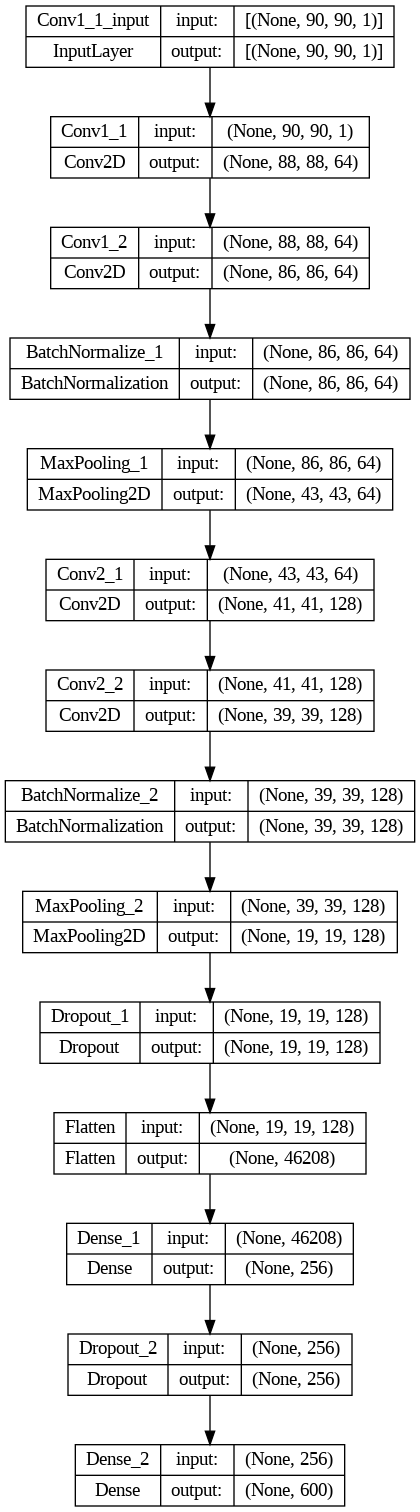

In [58]:
#Plot Id model graph in layers
plot_model(model[0], show_shapes=True, to_file=f'{TRAIN_DIR}/structure-SubjectID-model.png')

Model 2: `FingNum_Model`

In [59]:
model[1].summary()

Model: "FingerNum_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1_1 (Conv2D)            (None, 88, 88, 64)        640       
                                                                 
 Conv1_2 (Conv2D)            (None, 86, 86, 64)        36928     
                                                                 
 BatchNormalize_1 (BatchNor  (None, 86, 86, 64)        256       
 malization)                                                     
                                                                 
 MaxPooling_1 (MaxPooling2D  (None, 43, 43, 64)        0         
 )                                                               
                                                                 
 Conv2_1 (Conv2D)            (None, 41, 41, 128)       73856     
                                                                 
 Conv2_2 (Conv2D)            (None, 39, 39, 128)   

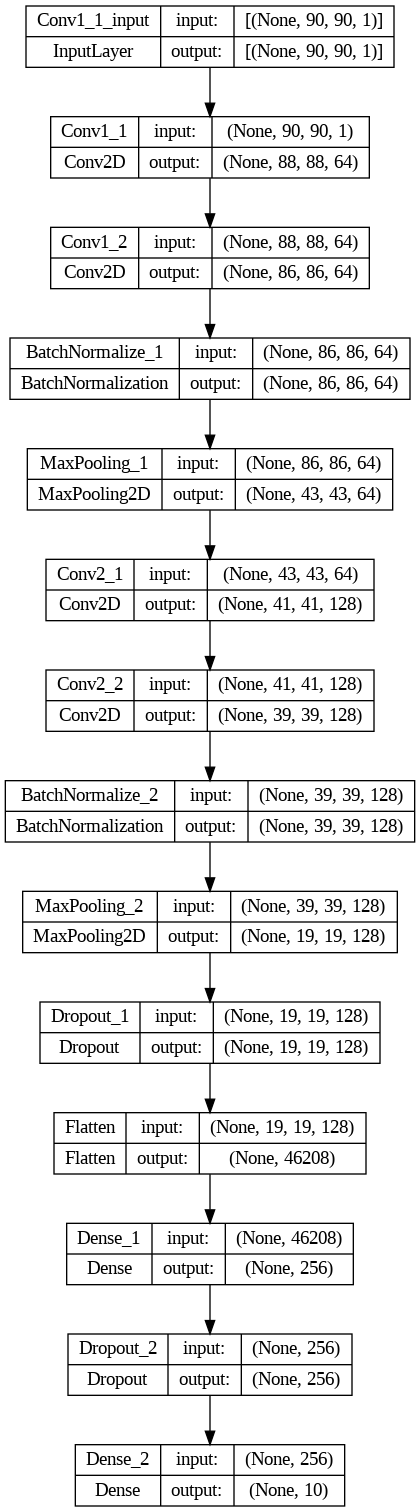

In [60]:
#Plot Finger model graph in layers
plot_model(model[1], show_shapes=True, to_file=f'{TRAIN_DIR}/structure-FingNum-model.png')

#### 3.2. Train model

Khởi tạo các giá trị cơ bản trước khi train

In [61]:
history = [0] * NETS
CallBack = [0] * NETS
ReduceLR_minlr = [1e-9, 1e-7]
epochs = 50
batch_size = 64

os.mkdir(f'{TRAIN_DIR}/models')
name_file = f'{TRAIN_DIR}/models/fingerprint-recognition-{TYPE_MODEL}'
name_file

'/content/runs//train1//models/fingerprint-recognition-base'

Gom các nhãn ID và fingerNum lại để áp dụng vòng lặp cho quá trình huấn luyện

In [62]:
y_train = [y_SubjectID_train, y_fingerNum_train]
y_val = [y_SubjectID_val, y_fingerNum_val]
y_test = [y_SubjectID_test, y_fingerNum_test]

Huấn luyện mô hình

In [63]:
for i in range(NETS):
    # Khởi tạo các giá trị của callbacks
    CallBack[i] = [
        callbacks.EarlyStopping(monitor='val_accuracy',
                                patience=4,
                                mode='max',
                                verbose=1,
                                restore_best_weights=True),

        callbacks.ReduceLROnPlateau(factor=0.1,
                                    patience=1,
                                    min_lr=ReduceLR_minlr[i],
                                    verbose=1),

        callbacks.ModelCheckpoint(filepath= f'{name_file}-best-{MODEL_NAME[i]}.h5',
                                  monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 3,
                                  save_best_only= True,
                                  save_weights_only= True)
        # callbacks.TensorBoard(log_dir="./log_dir/" + MODEL_NAME[i]),
        ]

    # Train model
    print(f'Starting to train {MODEL_NAME[i]}...\n')

    history[i] = model[i].fit(x_train, y_train[i],
                              batch_size=batch_size,
                              epochs=epochs,
                              validation_data=(x_val, y_val[i]),
                              verbose=1, callbacks=CallBack[i])

    print(f'Training {MODEL_NAME[i]} successfully !!!')

    # Save last model
    model[i].save_weights(filepath= f'{name_file}-last-{MODEL_NAME[i]}.h5')
    print(f'Save last model to {name_file}-last-{MODEL_NAME[i]}.h5\n')

Starting to train SubjectID_Model...

Epoch 1/50
616/616 [==============================] - ETA: 0s - loss: 6.5839 - accuracy: 0.0078
Epoch 1: val_accuracy improved from -inf to 0.02476, saving model to /content/runs//train1//models/fingerprint-recognition-base-best-SubjectID_Model.h5
616/616 [==============================] - 69s 109ms/step - loss: 6.5839 - accuracy: 0.0078 - val_loss: 6.3314 - val_accuracy: 0.0248 - lr: 1.0000e-04
Epoch 2/50
616/616 [==============================] - ETA: 0s - loss: 5.4492 - accuracy: 0.1205
Epoch 2: val_accuracy improved from 0.02476 to 0.40156, saving model to /content/runs//train1//models/fingerprint-recognition-base-best-SubjectID_Model.h5
616/616 [==============================] - 68s 110ms/step - loss: 5.4492 - accuracy: 0.1205 - val_loss: 3.7575 - val_accuracy: 0.4016 - lr: 1.0000e-04
Epoch 3/50
616/616 [==============================] - ETA: 0s - loss: 2.2944 - accuracy: 0.5852
Epoch 3: val_accuracy improved from 0.40156 to 0.95048, saving mo

#### 3.3. Visualize models

Mô hình trực quan quá trình huấn luyện dựa trên `loss` và `accuracy`

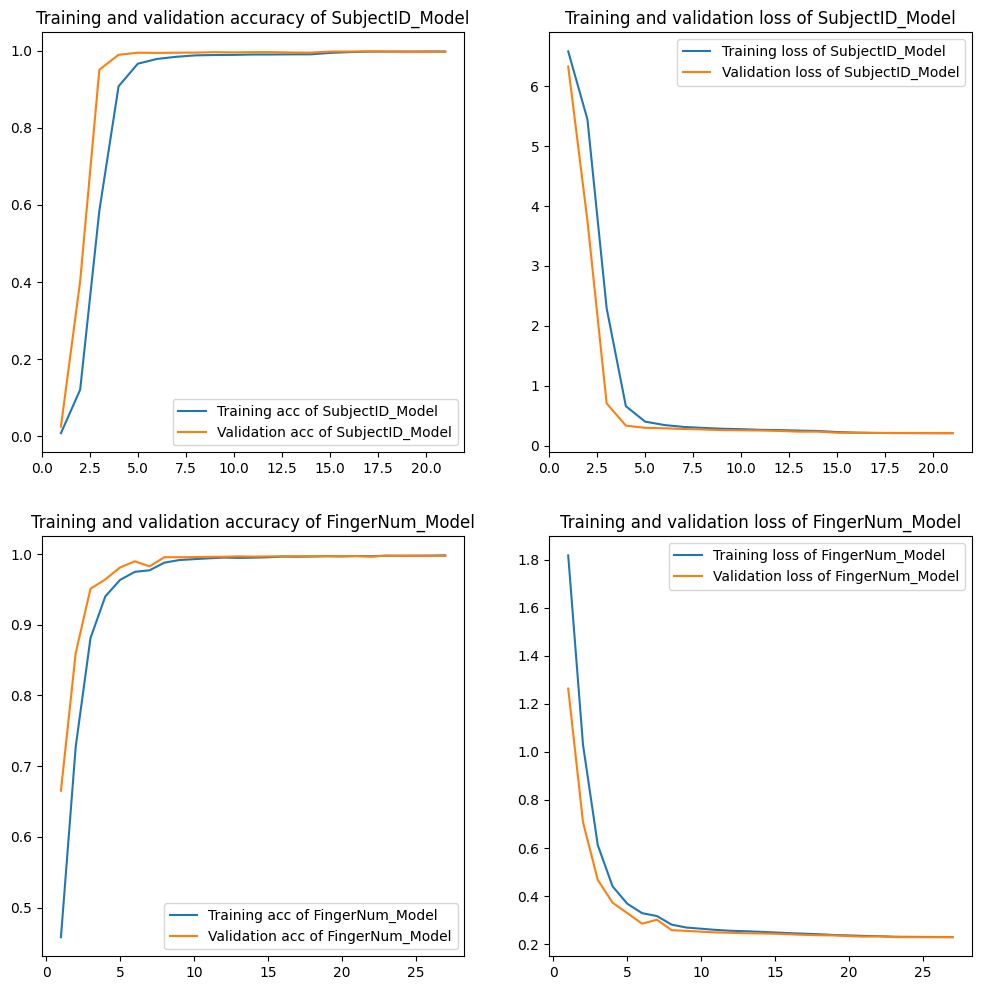

In [64]:
acc = [0] * NETS
val_acc = [0] * NETS
loss = [0] * NETS
val_loss = [0] * NETS

fig, ax = plt.subplots(2, 2, figsize = (12, 12))

for i in range(NETS):
    acc[i] = history[i].history['accuracy']
    val_acc[i] = history[i].history['val_accuracy']
    loss[i] = history[i].history['loss']
    val_loss[i] = history[i].history['val_loss']

    epochs = range(1, len(acc[i]) + 1)
    # plot figures models
    # ax[i][0].figure()
    ax[i][0].plot(epochs, acc[i], label = 'Training acc of '+ MODEL_NAME[i])
    ax[i][0].plot(epochs, val_acc[i], label = 'Validation acc of '+ MODEL_NAME[i])
    ax[i][0].set_title('Training and validation accuracy of '+ MODEL_NAME[i])
    ax[i][0].legend()

    # ax[i][1].figure()
    ax[i][1].plot(epochs, loss[i],  label='Training loss of '+ MODEL_NAME[i])
    ax[i][1].plot(epochs, val_loss[i], label='Validation loss of '+ MODEL_NAME[i])
    ax[i][1].set_title('Training and validation loss of '+ MODEL_NAME[i])
    ax[i][1].legend()

plt.savefig(f'{TRAIN_DIR}/acc-loss.png')

Kiểm tra kết quả trên tập test

In [65]:
testing_acc_Id = model[0].evaluate([x_test], [y_SubjectID_test], verbose=0)
print("ID recognition accuracy: ",testing_acc_Id[1]*100, "%")
testing_acc_finger = model[1].evaluate([x_test], [y_fingerNum_test], verbose=0)
print("Finger recognition accuracy: ",testing_acc_finger[1]*100, "%")

ID recognition accuracy:  99.75000023841858 %
Finger recognition accuracy:  99.90000128746033 %


Trực quan ma trận nhầm lẫn (`confusion matrix`)

188/188 [==============================] - 2s 10ms/step


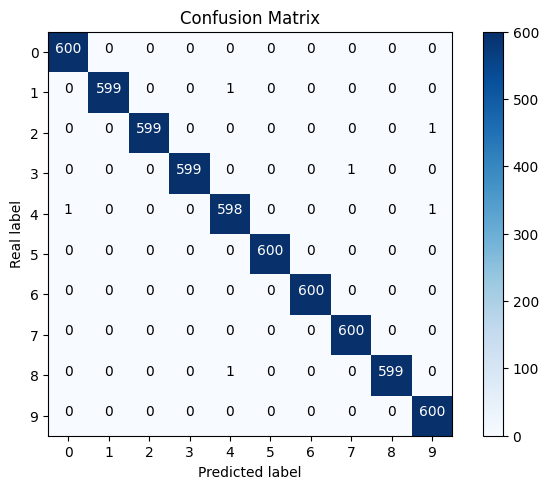

In [66]:
# Visualize finger prediction with confusion matrix
def plot_confusion_matrix(conmat, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(conmat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        conmat = conmat.astype('float') / conmat.sum(axis=1)[:, np.newaxis]

    thresh = conmat.max() / 2.
    for i, j in itertools.product(range(conmat.shape[0]), range(conmat.shape[1])):
        plt.text(j, i, conmat[i, j],
                 horizontalalignment="center",
                 color="white" if conmat[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Real label')
    plt.xlabel('Predicted label')
    plt.savefig(f'{TRAIN_DIR}/confusion-matrix.png')

# Predict the values from the test dataset
y_fingerNum_pred = model[1].predict(x_test)
# Convert predictions classes to one hot vectors
y_fingerNum_pred_classes = np.argmax(y_fingerNum_pred, axis=1)
# Convert test observations to one hot vectors
y_fingerNum_real = np.argmax(y_fingerNum_test, axis=1)
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_fingerNum_real, y_fingerNum_pred_classes)
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

Chọn ngẫu nhiên một ảnh trong tập test và ta sẽ xem kết mà ta nhận được

188/188 [==============================] - 2s 10ms/step
Infomation confirm! Fingerprint matches: person ID 299 left little


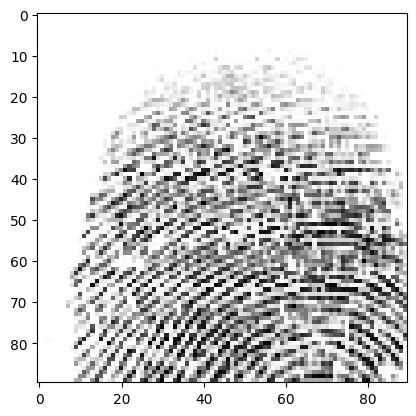

In [67]:
def show_fingername(fingernum):
    if fingernum>=5:
        fingername = "right "
        fingernum -= 5
    else: fingername = "left "

    if fingernum==0:
        fingername += "little"
    elif fingernum==1:
        fingername += "ring"
    elif fingernum==2:
        fingername += "middle"
    elif fingernum==3:
        fingername += "index"
    else:
        fingername += "thumb"
    return fingername

# Randomly pick a fingerprint from test data to predict both its Id and fingername
rand_fp_num = random.randint(0, x_test.shape[0]-1)
plt.imshow(x_test[rand_fp_num].reshape((90, 90)), cmap ='gray')
y_SubjectID_pred = model[0].predict(x_test)
Id_pred = np.argmax(y_SubjectID_pred[rand_fp_num])
Id_real = np.argmax(y_SubjectID_test[rand_fp_num])
fingerNum_pred = np.argmax(y_fingerNum_pred[rand_fp_num])
fingerNum_real = np.argmax(y_fingerNum_test[rand_fp_num])
if Id_pred==Id_real and fingerNum_pred==fingerNum_real:
    print("Infomation confirm! Fingerprint matches: person ID",Id_pred, show_fingername(fingerNum_pred))
else:
    print("Oops! Prediction is wrong!")